In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
import math
import utils
from collections import deque
import random
import seaborn as sns
from sklearn import preprocessing
from keras.layers import Dense, Dropout, LSTM, GRU, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
import create_model
import data_manipulator
import time
import data_reader
import finance_calculator

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)
plt.rcParams["figure.figsize"] = (5,3)
plt.rcParams["axes.titlesize"] = 17
plt.rcParams['savefig.dpi'] = 1200

tf.keras.utils.set_random_seed(2) # relu
#settings
%reload_ext autoreload
%autoreload 3
%config InteractiveShell.ast_node_interactivity = 'all'
%config InlineBackend.figure_format = 'retina'


Set Parameters

In [54]:
ASSET_TO_PREDICT = 'ik1'     
SEQ_LEN = 60 
FUTURE_PERIOD_PREDICT = 1 
EPOCHS = 30
BATCH_SIZE = 8
MODEL_TYPE = 'gru'

my_time = time.strftime('%m.%d.%H%M', time.localtime(int(time.time())))
NAME = f'{my_time}-{ASSET_TO_PREDICT}-{SEQ_LEN}-{FUTURE_PERIOD_PREDICT}-{MODEL_TYPE}-sigmoid-{EPOCHS}-{BATCH_SIZE}'
print(NAME)

02.08.2356-ik1-60-1-gru-sigmoid-30-8


In [55]:
dataset_df = data_reader.credit_selector(ASSET_TO_PREDICT)
dataset_df[f't+1'] = dataset_df[f'{ASSET_TO_PREDICT}'].shift(-FUTURE_PERIOD_PREDICT)
dataset_df['target'] = list(map(utils.classify, dataset_df[f'{ASSET_TO_PREDICT}'], dataset_df['t+1']))
model_build_df, model_test_df = data_manipulator.splitter(dataset_df, cutoff=0.10)
train_df, validation_df = data_manipulator.splitter(model_build_df, cutoff=0.10)
train_x, train_y = data_manipulator.preprocess(train_df, SEQ_LEN)
validation_x, validation_y = data_manipulator.preprocess(validation_df, SEQ_LEN)

Ups:  1395
Downs:  1258
Ups:  134
Downs:  107


In [56]:
if MODEL_TYPE == 'gru':
    model = create_model.gru_sigmoid(train_x)
elif MODEL_TYPE == 'gru_large':
    model = create_model.gru_sigmoid_large(train_x)
elif MODEL_TYPE == 'lstm':
    model = create_model.lstm_sigmoid(train_x)

In [57]:
checkpoint_filepath = f'models/{NAME}-checkpoint-' + '-{epoch:02d}-{val_accuracy:.3f}.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    mode='max')

In [58]:
# Train model
history = model.fit(
    train_x, 
    train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    callbacks=[checkpoint]
)

Epoch 1/30
315/315 [==============================] - ETA: 0s - loss: 0.8254 - accuracy: 0.5072
Epoch 1: val_accuracy improved from -inf to 0.51402, saving model to models/02.08.2356-ik1-60-1-gru-sigmoid-30-8-checkpoint--01-0.514.hdf5
315/315 [==============================] - 42s 113ms/step - loss: 0.8254 - accuracy: 0.5072 - val_loss: 0.6948 - val_accuracy: 0.5140
Epoch 2/30
315/315 [==============================] - ETA: 0s - loss: 0.7979 - accuracy: 0.4976
Epoch 2: val_accuracy did not improve from 0.51402
315/315 [==============================] - 34s 109ms/step - loss: 0.7979 - accuracy: 0.4976 - val_loss: 0.7016 - val_accuracy: 0.5047
Epoch 3/30
315/315 [==============================] - ETA: 0s - loss: 0.7718 - accuracy: 0.5032
Epoch 3: val_accuracy did not improve from 0.51402
315/315 [==============================] - 34s 109ms/step - loss: 0.7718 - accuracy: 0.5032 - val_loss: 0.7073 - val_accuracy: 0.5140
Epoch 4/30
315/315 [==============================] - ETA: 0s - loss:

In [59]:
loss, acc = model.evaluate(validation_x, validation_y, verbose=0)
print("Model, Test loss: {:5.2f}".format(loss))
print("Model, test accuracy: {:5.2f}%".format(100 * acc))

model.save(f"models/{NAME}.hdf5")
if hasattr(history, 'history'):
    np.save(f'history/{NAME}.npy',history.history)
    print("Saved history") #should happen at first run of this block after model.fit ran

Model, Test loss:  0.69
Model, test accuracy: 56.07%
Saved history


Last trained model name is set to: 02.08.2356-ik1-60-1-gru-sigmoid-30-8


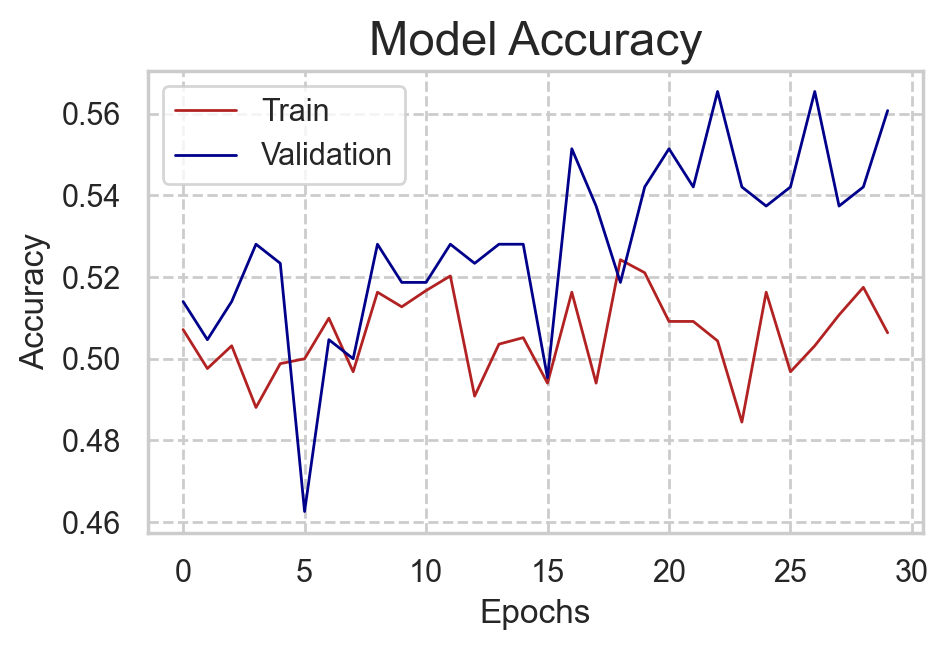

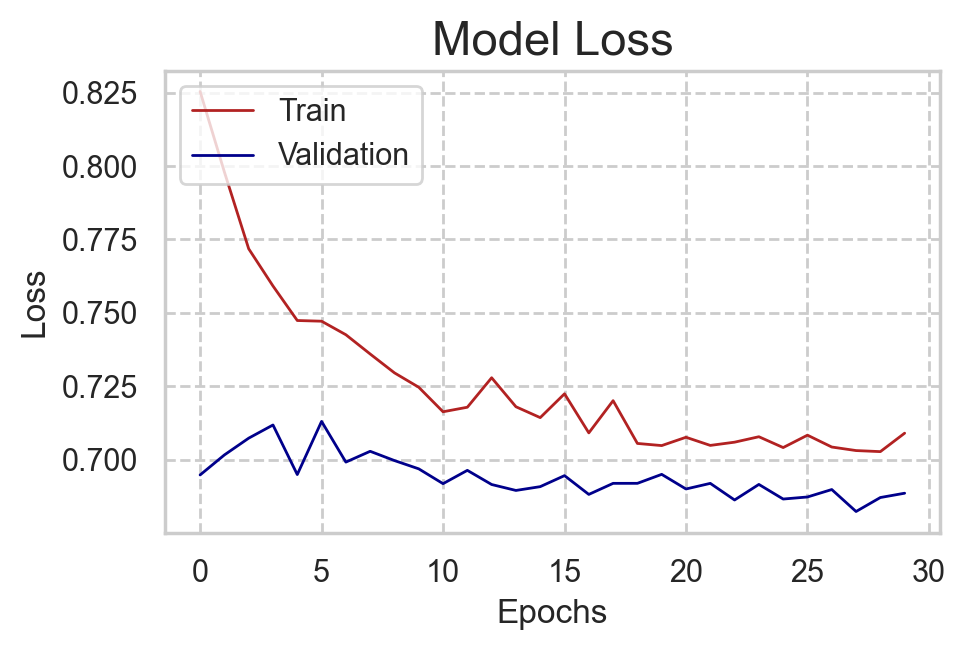

In [60]:
# load back history data
model_load = keras.models.load_model(f'models/{NAME}.hdf5')
history_load = np.load(f'history/{NAME}.npy',allow_pickle='TRUE').item()

fig1, axs1 = utils.plot_history_data_accuracy(history_load)
fig2, axs2 = utils.plot_history_data_loss(history_load)

utils.set_last_trained_model_name(NAME)